In [3]:
import numpy as np 
from scipy.integrate import odeint
import matplotlib.pyplot as plt 
import random

### Modeling single-gene expression
Cells are intrinsically noisy biochemical reactors: low reactant numbers coupled with orders of magnitude differences in production and decay rates among reactants can lead to significant statistical fluctuations in molecule numbers. This noise can play an important role in single cell behavior , which is hidden when only population averages are measured. Nevertheless, this cell-to-cell heterogeneity may play an important role in bacterial populations and has been linked to stress survival, mutation rate variation and stochastic cell fate switching (for a recent review see Sampaio and Dunlop, 2020).

Deterministic simulation of ODE's breaks down at the cell-level where the numbers of agents becomes small, reactions occur in a specific order rather than simultaneously and dynamics are governed by probabilistic  rather than deterministic processes. Gillespie’s algorithm is great way of implementing this probabilistic nature of the cellular system.

Here, we will simulate the production of a protein from a single DNA template. Below is the diagram of the ODE system.  
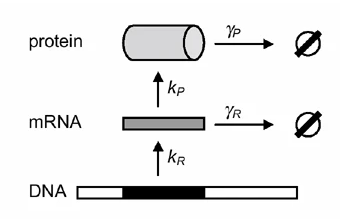  
mRNA molecules are transcribed at rate $k_R$ from the template DNA strand. Proteins are translated at a rate $k_P$ from each mRNA molecule. Proteins and mRNA degrade at rates $γ_P$ and $γ_R$, respectively.

Stochastic gene expression has been studied by looking at the expression of fluorescent protein. See below and Elowitz et al (2002).   
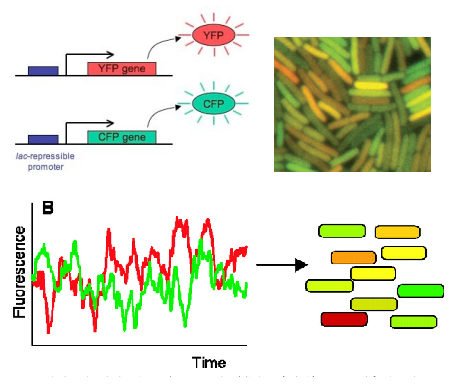

#### References
Sampaio NMV, Dunlop MJ. Functional roles of microbial cell-to-cell heterogeneity and emerging technologies for analysis and control. Curr Opin Microbiol. 2020 Oct;57:87-94.   
Elowitz MB, Levine AJ, Siggia ED, Swain PS. Stochastic gene expression in a single cell. Science. 2002 Aug 16;297(5584):1183-6.   
Ozbudak, E., Thattai, M., Kurtser, I. et al. Regulation of noise in the expression of a single gene. Nat Genet 31, 69–73 (2002).   
Thattai, M. and Van Oudenaarden, A., 2001. Intrinsic noise in gene regulatory networks. Proceedings of the National Academy of Sciences, 98(15), pp.8614-8619.  
Rao, C., Wolf, D. & Arkin, A. Control, exploitation and tolerance of intracellular noise. Nature 420, 231–237 (2002).   


Let's first try to simulate protein production using a deterministic method (ODEINT method). Based on the diagram what are the ODE's and build the model here.

In [7]:
def model(y,t,kr,gr,kp,gp):
    RNA,Protein=y
    dRNAdt = kr - gr*RNA
    dProteindt = kp * RNA - gp * Protein
    
    return dRNAdt, dProteindt

Now let's simulate and plot protein production against time. Use the following initial conditions. Lets assume there is initially no mRNA and Protein present.   
$k_R = 0.08$   
$k_P = 1$   
$γ_P = 0.02$   
$γ_R = 0.12$  

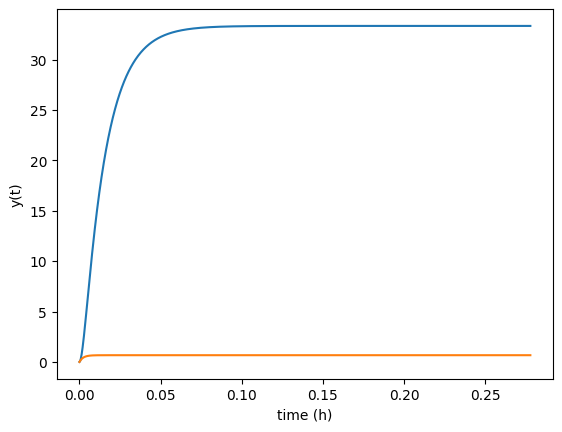

In [12]:
RNA_0 = 0
Protein_0 = 0
Y=RNA_0,Protein_0

kr=0.08 #trancription rate /s*DNA
gr=0.12 # decay rate RNA /s
kp=1#translation rate /s*mRNA
gp=0.02 #decay rate protein /s


parameters=(kr,gr,kp,gp)
t = np.linspace(0,1000, num=1000)

y = odeint(model,Y,t,args=parameters)

t=t/60/60
RNA_determ,Protein_determ=np.array(y).T
plt.plot(t,Protein_determ)
plt.plot(t,RNA_determ)
plt.xlabel('time (h)')
plt.ylabel('y(t)')
plt.show()

Let us now simulate the same system of ODE's but using the Gillespie algorithm. Define the reaction events and their rates based on the ODEs and build the algorithm.

In [25]:
RNA_0 = 0
Protein_0 = 0
Y=RNA_0,Protein_0

kr=0.08 #trancription rate /s*DNA
gr=0.12 # decay rate RNA /s
kp=1#translation rate /s*mRNA
gp=0.02 #decay rate protein /s

time = 0
N_list = [(Protein_0,RNA_0,time)]
for tick in range(1000):
    
    time = N_list[-1][2]
    RNA = N_list[-1][1]
    Protein = N_list[-1][0]
    
    Rate1= kr
    Rate2= gr * RNA
    Rate3= kp * RNA
    Rate4 = gp * Protein

    Rtot = Rate1 + Rate2 + Rate3 + Rate4
    
    Pevent1 = Rate1/Rtot
    Pevent2 = Rate2/Rtot
    Pevent3 = Rate3/Rtot
    Pevent4 = Rate4/Rtot
    # define time till next event
    tau = np.random.exponential(1/Rtot)
    time_next = time + tau
    
    #draw which event happens next
    Random_number = np.random.uniform()
    if Random_number <= Pevent1:
        RNA += 1
        Protein = Protein
    elif Pevent1 <= Random_number <= (Pevent1 + Pevent2):
        RNA -= 1
        Protein = Protein

    elif (Pevent1 + Pevent2) <= Random_number <= (Pevent1 + Pevent2 + Pevent3): 
        Protein += 1
        RNA = RNA
    
    else: 
        Protein -= 1
        RNA = RNA
    
    N_list.append((Protein,RNA,time_next))
    
    

In [26]:
Protein_list  = [y[0] for y in N_list]
RNA_list  = [y[1] for y in N_list]
time_list  = [y[2] for y in N_list]

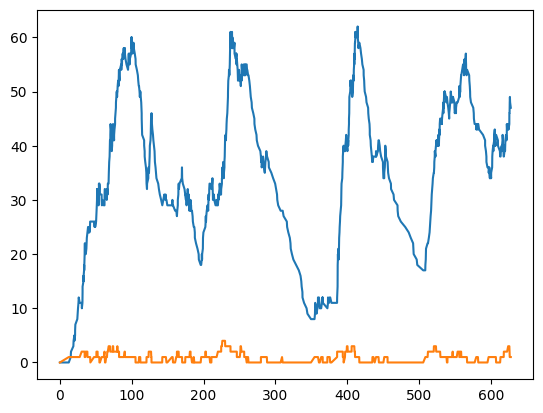

In [27]:
plt.plot(time_list,Protein_list)
plt.plot(time_list,RNA_list)

In [19]:
RNA_0 = 0
Protein_0 =0
Y0=RNA_0,Protein_0

kr=0.08 #trancription rate /s*DNA
gr=0.12 # decay rate RNA /s
kp=1#translation rate /s*mRNA
gp=0.02 #decay rate protein /s

time_end=1000

time_start=0
Y_list=[(Y0,time_start)]



while Y_list[-1][1]<=time_end:
    RNA_current,Protein_current=Y_list[-1][0]

    Rate_lists=[kr,gr*RNA_current,kp*RNA_current,gp*Protein_current]
    
    R_sum=np.sum(Rate_lists)
    #determine time to next reaction
    tau = np.random.exponential(1/R_sum) 
    time=Y_list[-1][1]+tau
    #determine which event is updated. Birth +1 , Death -1

    chosen_event=random.choices([1,2,3,4], [Rate_lists[0]/R_sum,Rate_lists[1]/R_sum,Rate_lists[2]/R_sum,Rate_lists[3]/R_sum])[0] 

    if chosen_event==1:
        RNA_next=RNA_current+1
        Protein_next=Protein_current+0
    elif chosen_event==2:
        RNA_next=RNA_current-1
        Protein_next=Protein_current+0
    elif chosen_event==3:
        RNA_next=RNA_current+0
        Protein_next=Protein_current+1
    elif chosen_event==4:
        RNA_next=RNA_current+0
        Protein_next=Protein_current-1
        
    Y_list.append(((RNA_next,Protein_next),time))

Plot protein production of the Gillespie simulation. You can plot it together with the deterministic simulation to compare both simulations. Think about why the Gillespie and deterministic simulation differ. 

C:\Users\u0072317\AppData\Local\Temp\ipykernel_26008\385517693.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y,time=np.array(Y_list).T


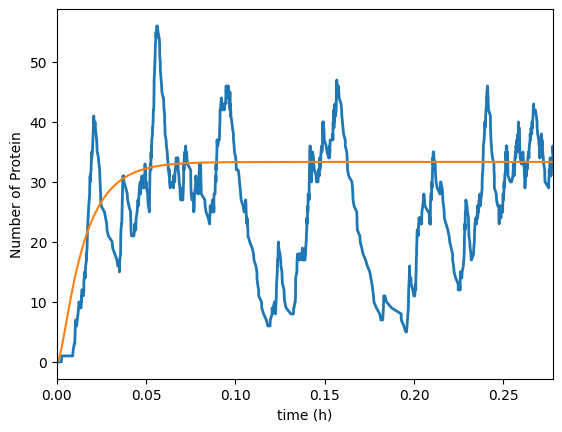

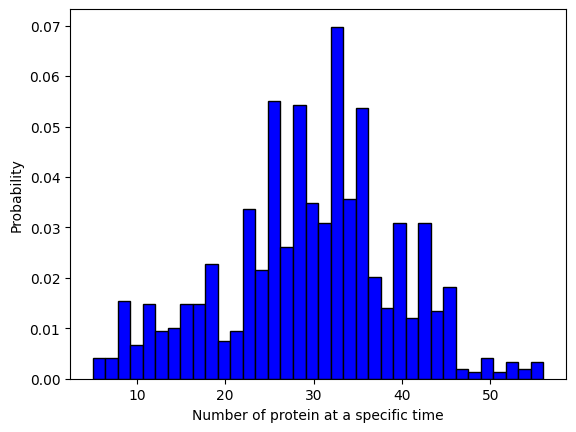

29.54847908745247


In [28]:

Y,time=np.array(Y_list).T
RNA,Protein=[y[0] for y in Y],[y[1] for y in Y]

time_m=time/60/60
time_e=time_end/60/60
plt.plot(time_m,Protein,linewidth=2.0,alpha=1)
plt.plot(t,Protein_determ)
plt.xlim(0,time_e)
plt.xlabel('time (h)')
plt.ylabel('Number of Protein')
plt.show()


from scipy.stats import norm
mu, std = norm.fit(Protein[100:])
plt.hist(Protein[100:], color = 'blue', edgecolor = 'black', density=True,
         bins = int(180/5))

plt.xlabel('Number of protein at a specific time')
plt.ylabel('Probability')
plt.show()
print(mu)

C:\Users\u0072317\AppData\Local\Temp\ipykernel_26008\1413668156.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y,time=np.array(Y_list).T


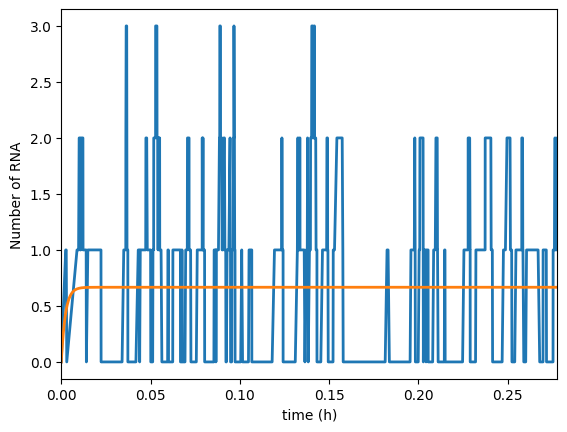

In [21]:

Y,time=np.array(Y_list).T
RNA,Protein=[y[0] for y in Y],[y[1] for y in Y]

time_m=time/60/60
time_e=time_end/60/60

plt.plot(time_m,RNA,linewidth=2.0,alpha=1)
plt.plot(t,RNA_determ,linewidth=2.0,alpha=1)
plt.xlim(0,time_e)
plt.xlabel('time (h)')
plt.ylabel('Number of RNA')
plt.show()